# Project

### 1 Load Packages

In [1]:
# ========================TensorFlow========================
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.2.0-rc3


In [2]:
# ========================General========================
import json
import joblib
import scipy
import pandas as pd
import numpy as np
import requests
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# ========================Ploting========================
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
# ========================Data Preprocessing========================
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# ========================Modeling========================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# ========================Evaluation========================
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef, f1_score
# ========================Deep Learning========================
# MLP
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, AlphaDropout
# ================================================

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2 Load dataset

In [0]:
# load movie
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df = df[df.release_date.notnull()]
    df = df[df.release_date.str.contains("^\d{4}\-\d{2}.")]
    df = df[df.release_date>="1970-01-01"]
    df['release_year'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.year) if x==x else None)
    df['release_month'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.month) if x==x else None)
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [0]:
# load movie credits
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [0]:
# Columns that existed in IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']

# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'box_office',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}


def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['companies_1'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['companies_2'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['companies_3'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [0]:
# link to raw data: https://drive.google.com/file/d/19C8m6CwRu9I-eydnTbp4gPCp_eeFMb7t/view
movies_path = '/content/drive/My Drive/Colab Notebooks/NEU-7390 Advances Data Sci Architecture/movie_data.csv'
# link to raw data: https://drive.google.com/file/d/1mnH9UaaXZ-gP3At0Q2Qus-Gz0EJOqiYx/view
credits_path = '/content/drive/My Drive/Colab Notebooks/NEU-7390 Advances Data Sci Architecture/movie_credits.csv'

In [0]:
movies = load_tmdb_movies(movies_path)
credits = load_tmdb_credits(credits_path)
raw_data =convert_to_original_format(movies, credits)

### 3 Data Preprocessing
*   Handling Missing Values
*   Drop Duplication Values
*   Drop Outliers

#### 3.1 Handling Missing Values

In [9]:
raw_data.head(1)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,box_office,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,release_year,release_month,country,director_name,actor_1_name,actor_2_name,actor_3_name,companies_1,companies_2,companies_3
3,0,Comedy,NaN,21624,,NaN,Jatts in Golmaal,Jatts in Golmal is an Comedy based movie. In w...,0.6,[],[],2003-02-21,0.0,NaN,[],Released,NaN,Jatts in Golmaal,0.0,0.0,2003,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
def missing_value_table(df):
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent = round(((df.isnull().sum()/len(df))*100),2).sort_values(ascending=False)
    missing_data = pd.concat([total_missing, percent], axis=1, keys=['total Missing', 'Percent(%)'])
    print("=====Missing Value Check Table(only list not 0% column)=====")
    print(missing_data[missing_data['Percent(%)'] != 0])
    if missing_data[missing_data['Percent(%)'] != 0].shape[0] == 0:
        print("=====No Missing Value in Data after Checking=====")

In [11]:
missing_value_table(raw_data)

=====Missing Value Check Table(only list not 0% column)=====
               total Missing  Percent(%)
homepage               36258       84.18
companies_3            35398       82.18
actor_3_name           29391       68.24
actor_2_name           29179       67.74
director_name          29042       67.43
companies_2            28811       66.89
actor_1_name           28747       66.74
tagline                27682       64.27
companies_1            16102       37.38
country                 8171       18.97
language                5137       11.93
overview                1906        4.43
duration                 346        0.80


In [0]:
# drop homepage & tagline, which are useless and also have many missing values
raw_data.drop(['homepage','tagline'], axis=1, inplace=True)

#### 3.2 Drop Duplication Values and Unseen Features

In [0]:
# Drop Duplication Values
drop_duplicates_subset = ('budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title','overview', 'popularity','release_date', 'box_office', 'duration','status','movie_title','vote_average','num_voted_users')
raw_data.drop_duplicates(subset=drop_duplicates_subset, keep='first', inplace=True)

In [0]:
# Drop features that only know after movie release, 'box_office' column will be dropped later after define the success of each movie
raw_data.drop(['num_voted_users', 'popularity'], axis=1, inplace=True)

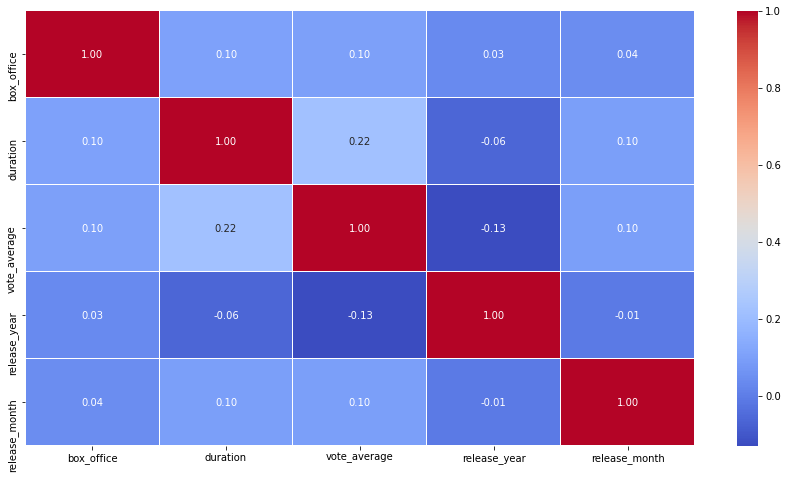

In [15]:
# Correlation matrix between numerical values
plt.figure(figsize = (15,8))
g = sns.heatmap(raw_data[list(raw_data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

#### 3.3 Drop Outliers

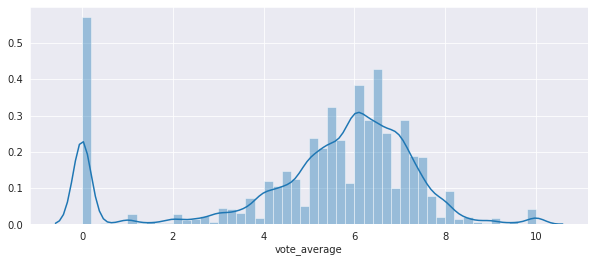

In [16]:
# Plot the histgram of vote_average
plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
sns.distplot(raw_data.vote_average, kde=True)
plt.show()

In [17]:
# Drop rows in dataset containing 0 and below vote average
before_rows = len(raw_data)
raw_data = raw_data[raw_data['vote_average'] > 0]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 4915 rows;
Current Total rows: 38157


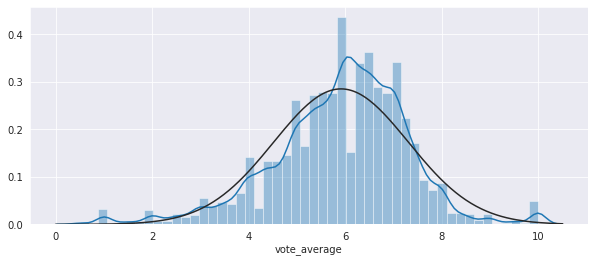

In [18]:
# After dropping outliers, the distribution of vote average(blue line) is more like normal distribution(black line)
plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
sns.distplot(raw_data.vote_average,fit=scipy.stats.norm, kde=True)
plt.show()

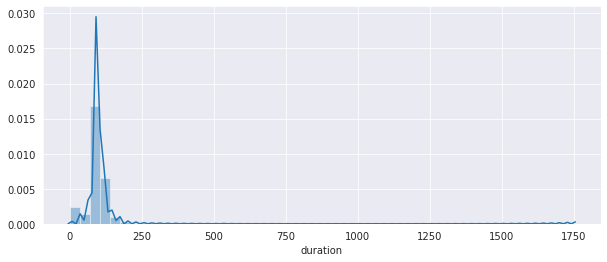

In [19]:
# Plot the histgram of duration
plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
sns.distplot(raw_data.duration, kde=True)
plt.show()

In [20]:
# Based on common sence, duration of a movie is between 90-120 mins, duration < 10 or duration > 300 is unlikely possible
# Drop rows in dataset of which duration > 10 and duration < 300
before_rows = len(raw_data)
raw_data = raw_data[10 < raw_data['duration']]
raw_data = raw_data[raw_data['duration'] < 300]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 2604 rows;
Current Total rows: 35553


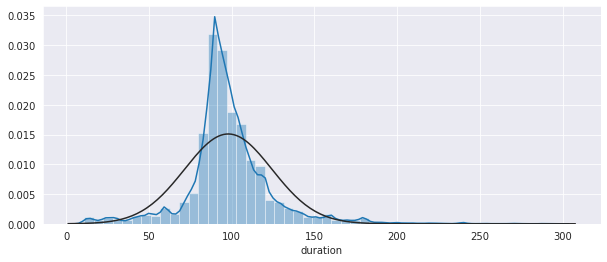

In [21]:
# After dropping outliers, the distribution of vote average(blue line) is more like normal distribution(black line)
plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
sns.distplot(raw_data.duration,fit=scipy.stats.norm, kde=True)
plt.show()

In [22]:
missing_value_table(raw_data)

=====Missing Value Check Table(only list not 0% column)=====
               total Missing  Percent(%)
companies_3            28037       78.86
actor_3_name           22693       63.83
actor_2_name           22547       63.42
director_name          22325       62.79
actor_1_name           22214       62.48
companies_2            21786       61.28
companies_1            10498       29.53
country                 4629       13.02
language                2349        6.61
overview                 522        1.47


### 4 Data Wrangling: Define a movie is successful or unsuccessful and edit features
*   Define Label
*   Budget
*   Release Year
*   Duration
*   Genres
*   Director
*   Company

#### 4.1 Define Label

In [23]:
# Total columns fot dataset
raw_data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'box_office', 'duration', 'spoken_languages', 'status',
       'movie_title', 'vote_average', 'release_year', 'release_month',
       'country', 'director_name', 'actor_1_name', 'actor_2_name',
       'actor_3_name', 'companies_1', 'companies_2', 'companies_3'],
      dtype='object')

In [24]:
raw_data.budget = raw_data.budget.astype(float)
raw_data.describe(percentiles=[.10,.25,.5,.75,.9,.99])

,budget,box_office,duration,vote_average,release_year,release_month
count,3.555300e+04,3.555300e+04,35553.000000,35553.000000,35553.000000,35553.000000
mean,4.276101e+06,1.092765e+07,98.032346,5.912713,1998.542008,6.291733
std,1.688069e+07,6.008564e+07,26.437635,1.369054,11.226147,3.701844
min,0.000000e+00,0.000000e+00,11.000000,0.500000,1970.000000,1.000000
10%,0.000000e+00,0.000000e+00,75.000000,4.100000,1980.000000,1.000000
25%,0.000000e+00,0.000000e+00,87.000000,5.200000,1992.000000,3.000000
50%,0.000000e+00,0.000000e+00,95.000000,6.000000,2003.000000,6.000000
75%,0.000000e+00,0.000000e+00,107.000000,6.800000,2007.000000,10.000000
90%,9.000000e+06,1.052400e+07,125.000000,7.400000,2010.000000,11.000000
99%,8.448000e+07,2.609950e+08,182.000000,9.000000,2011.000000,12.000000


Based on our [research](https://io9.gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305), we assume that the box office of a profitable movie is two times more than its budget.

For this project, successful movies is a movie which got vote_score more than vote_score mean and get box office two times more than budget.

In [0]:
vote_score_mean = raw_data['vote_average'].mean()
raw_data['box/budget'] = raw_data['box_office']/raw_data['budget']
raw_data['success'] = raw_data['vote_average'].map(lambda s :1  if s > vote_score_mean else 0)
raw_data['success'] = raw_data['box/budget'].map(lambda s :1  if s > 2 else 0)

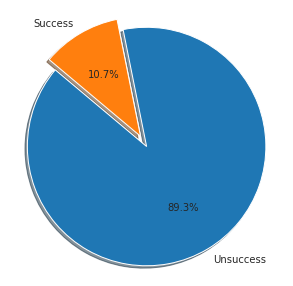

In [26]:
# Data to plot
plt.figure(figsize=(5,5))
labels = ["Unsuccess","Success"]
sizes = raw_data['success'].value_counts(sort=False)
explode = (0.1,0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [0]:
# Drop 'gross','box/budget' after define the success of each movie
raw_data.drop(['box/budget', 'box_office'], axis=1, inplace=True)

#### 4.2 Budget

In [0]:
raw_data.budget=raw_data.budget.astype(int)

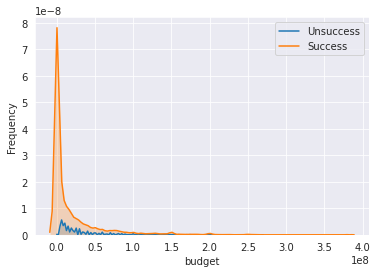

In [29]:
# budget distibution
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 0) ], shade = True)
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 1) ], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

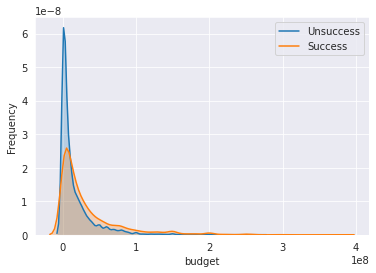

In [30]:
# Non-zero budget distibution
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 0)], shade = True)
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 1)], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

In [31]:
print("Percent of zero budget: {}%".format(round((raw_data.budget==0).sum()/len(raw_data)*100, 2)))

Percent of zero budget: 79.44%


In [32]:
# Based on common sence, no moive can be made with zero budget. So drop rows with zero budget
before_rows = len(raw_data)
raw_data = raw_data[raw_data.budget!=0]
print('Delete {} rows;\nCurrent rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 28243 rows;
Current rows: 7310


In [0]:
# The Q1,Q2(median),Q3,95% of budget of non-zero movies
non_zero_budget_Q1 = raw_data.budget[raw_data.budget>0].quantile(0.25)
non_zero_budget_median = raw_data.budget[raw_data.budget>0].quantile(0.5)
non_zero_budget_Q3 = raw_data.budget[raw_data.budget>0].quantile(0.75)
non_zero_budget_95 = raw_data.budget[raw_data.budget>0].quantile(0.95)

In [0]:
'''
Create new feature of budget
0 < Budget < Q1 => VeryLowBudget
Q1 <= Budget < Median =>LowBudget
Median <= Budget < Q3 => MedBudget
Q3 <= Budget < 95% => HighBudget
95% <= Budget => VeryHighBudget
'''
raw_data['VeryLowBudget'] = raw_data['budget'].map(lambda s: 1 if 0< s < non_zero_budget_Q1 else 0)
raw_data['LowBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q1 <= s < non_zero_budget_median else 0)
raw_data['MedBudget'] = raw_data['budget'].map(lambda s: 1 if  non_zero_budget_median <= s < non_zero_budget_Q3 else 0)
raw_data['HighBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q3 <= s < non_zero_budget_95 else 0)
raw_data['VeryHighBudget'] = raw_data['budget'].map(lambda s: 1 if s >= non_zero_budget_95 else 0)

#### 4.3 Release Year

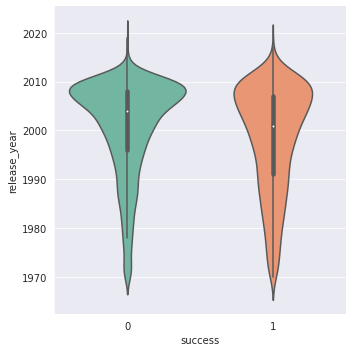

In [35]:
# Release Year Distribution
g = sns.factorplot(y="release_year",x="success",data=raw_data,kind="violin", palette = "Set2")

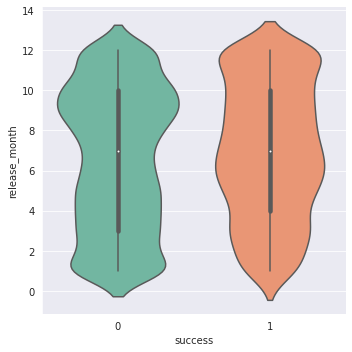

In [36]:
# Release Month Distribution
g = sns.factorplot(y="release_month",x="success",data=raw_data,kind="violin", palette = "Set2")

#### 4.4 Duration

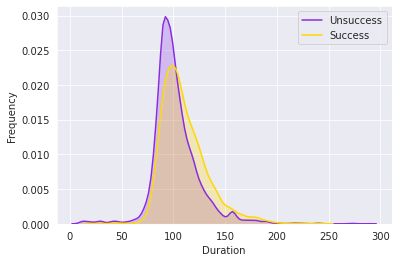

In [37]:
# duration distibution show success or unsuccess movies are all normal distributed
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 0) ], color="blueviolet", shade = True)
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 1) ], ax =g, color="gold", shade= True)
g.set_xlabel("Duration")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

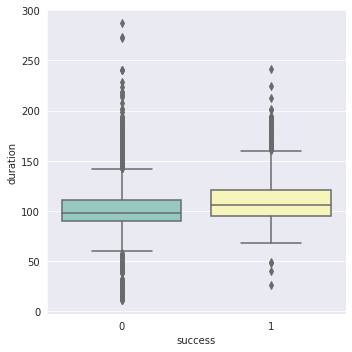

In [38]:
# duration distibution by success
g = sns.factorplot(x="success", y = "duration",data = raw_data, kind="box", palette = "Set3")

In [0]:
'''
Based on common sence
duration <90          => Short Movie
90 <= duration < 120  => Normal Movie
120 <= duration       => Long Movie
'''
raw_data['ShortMovie'] = raw_data['duration'].map(lambda s: 1 if s < 90 else 0)
raw_data['NormalMovie'] = raw_data['duration'].map(lambda s: 1 if 90 <= s < 120 else 0)
raw_data['LongMovie'] = raw_data['duration'].map(lambda s: 1 if s >= 120 else 0)

#### 4.5 Genres
Since a movie may have multiple genres, we will use one-hot encoding to transform the column of Genres

In [40]:
raw_data.genres.head()

8                         Crime|Comedy
9                Action|Thriller|Crime
10                         Documentary
12    Adventure|Action|Science Fiction
13                    Animation|Family
Name: genres, dtype: object

In [0]:
def Obtain_list_Occurences(data, column):
    # Obtaining list of column
    listOcc = []
    for i in data[column]:
        split_genre = list(map(str, i.split('|')))
        for j in split_genre:
            if j not in listOcc:
                listOcc.append(j)
    return listOcc

In [0]:
genre = []
genre = Obtain_list_Occurences(raw_data, "genres")
# Drop empty string
genre = list(filter(lambda x:len(x)>0, genre))

In [0]:
# Encoding genre
for w in genre:
    raw_data[w] = raw_data['genres'].map(lambda s: 1 if w in str(s) else 0)

In [44]:
raw_data.loc[:,genre].head()

,Crime,Comedy,Action,Thriller,Documentary,Adventure,Science Fiction,Animation,Family,Drama,Romance,Fantasy,War,Music,Western,Mystery,History,Horror,TV Movie
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


#### 4.6 Director

In [0]:
raw_data.director_name.fillna('unknown', inplace=True)

In [0]:
def to_frequency_table(data):
    frequency = {}
    for key in data:
        if key in frequency and key:
            frequency[key] += 1
        else:
            frequency[key] = 1
    return frequency

In [0]:
director_dic = to_frequency_table(raw_data['director_name'])
director_list = list(director_dic.items())
director_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
director_list=list(filter(lambda x:x[0]!='unknown', director_list))

In [0]:
# Funtion to find top xx in list
def Top(List, top_num):
    Top = list()
    for i in range(0, top_num):
        Top.append(List[i][0])
    return Top

In [49]:
# Encoding Top 100 director
top_list = Top(director_list, 100)
for w in top_list:
    raw_data[w] = raw_data['director_name'].map(lambda s: 1 if w in str(s) else 0)
# Encoding non-Top 50 director in 'other_director' columns
raw_data['other_director'] = raw_data['director_name'].map(lambda x:1 if x not in top_list else 0)
print("Total movies of top directors: {};\nTotal movies of non-top directors: {};\nTotal movies: {}.".format(raw_data[top_list].sum().sum(), raw_data.other_director.sum(), len(raw_data)))

Total movies of top directors: 1008;
Total movies of non-top directors: 6302;
Total movies: 7310.


#### 4.7 Company

In [0]:
# Fill none value in 3 actor columns
raw_data['companies_1'].fillna('unknown',inplace=True)
raw_data['companies_2'].fillna('unknown',inplace=True)
raw_data['companies_3'].fillna('unknown',inplace=True)

In [0]:
company_dic = to_frequency_table(raw_data['companies_1'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_1=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
company_dic = to_frequency_table(raw_data['companies_2'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_2=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
company_dic = to_frequency_table(raw_data['companies_2'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_3=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
# Combine all company in one list
full_company_list=sorted(company_list_1+company_list_2+company_list_3)
company_dict={}
for a,b in full_company_list:
    if a not in company_dict.keys():
        company_dict[a] = b
    elif a in company_dict.keys():
        company_dict[a] = company_dict.get(a) + b

combined_company_list = list(company_dict.items())
combined_company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
combined_company_list=list(filter(lambda x:x[0]!='unknown', combined_company_list))

In [55]:
total=0
for a,b in combined_company_list:
    total += b

top_index = 0
top_count = 0
for a,b in combined_company_list:
    if b >= 20:
        top_count += b
        top_index += 1
    else:
        break
print(top_index)
print(len(combined_company_list))
print(combined_company_list[top_index])

80
4745
('DC Comics', 19)


In [0]:
# Create company columns
toplist = Top(combined_company_list, top_index)
for w in toplist:
    raw_data[w] = 0

In [0]:
# Encoding Top 80 company
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_1'].map(lambda x: 1 if x in w else 0)
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_2'].map(lambda x: 1 if x in w else 0)
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_3'].map(lambda x: 1 if x in w else 0)

#### 4.8 Drop Columns

In [0]:
raw_data.drop(['budget','genres','id','plot_keywords','language','original_title','overview',
               'production_companies','production_countries','release_date','duration','spoken_languages','status','movie_title','vote_average','country',
               'director_name',
               'actor_1_name','actor_2_name','actor_3_name',
               'companies_1','companies_2','companies_3'], axis=1, inplace=True)

In [59]:
# Check missing value
missing_value_table(raw_data)

=====Missing Value Check Table(only list not 0% column)=====
Empty DataFrame
Columns: [total Missing, Percent(%)]
Index: []
=====No Missing Value in Data after Checking=====


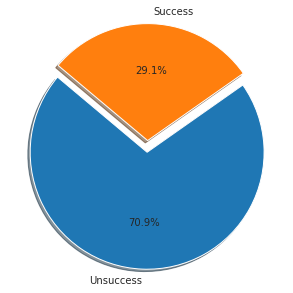

In [60]:
# Success and Unsuccss ratio after data manipulation
plt.figure(figsize=(5,5))
labels = ["Unsuccess","Success"]
sizes = raw_data['success'].value_counts(sort=False)
explode = (0.1,0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

### 5 Modeling
*   Define Useful Functions
*   Split Data
*   K-Nearest Neighbors
*   Decision Tree
*   Random Forest
*   Gradient Boosting
*   Conclusion Model Performance
*   Model Test

#### 5.0 Define Useful Functions

In [0]:
import itertools
def plot_confusion_matrix(cm, f1,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    f1_score = f1

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label\nAccuracy over Test Data={:0.2f}\nF1-Score={:0.2f}'.format(accuracy, f1_score))
    plt.show()

In [0]:
def model_selection(clf, x_train_all, y_train_all, x_train, y_train, x_test, y_test):
    clf.fit(x_train,y_train)
    score_all=cross_val_score(clf, x_train_all, y_train_all, cv=5)
    avg_score=score_all.mean()
    print("Accuracy Score based on 5-fold Cross Validation: {}\n".format(round(avg_score,2)))
    y_test_pred=clf.predict(x_test)
    cm = confusion_matrix(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    plot_confusion_matrix(cm,f1, normalize = False, target_names = ['failed','success'],title = "Confusion Matrix over Test Data")

#### 5.1 Split Data

In [0]:
# Split data into train and test set
data = raw_data
y = data['success']
y = np.array(y).reshape(-1,1)
x = data.drop('success',axis=1)
# release_year and release_month has fixed range => Min-Max Normalization
minmax = MinMaxScaler()
x[['release_year','release_month']] = minmax.fit_transform(x[['release_year','release_month']])

In [0]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,random_state=10, test_size=.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11, test_size=0.25)

In [65]:
print('x_train_all: {}; y_train_all: {}.'.format(x_train_all.shape, y_train_all.shape))
print('x_train: {}; y_train: {}.'.format(x_train.shape, y_train.shape))
print('x_valid: {}; y_valid: {}.'.format(x_valid.shape, y_valid.shape))
print('x_test: {}; y_test: {}.'.format(x_test.shape, y_test.shape))

x_train_all: (5482, 210); y_train_all: (5482, 1).
x_train: (4111, 210); y_train: (4111, 1).
x_valid: (1371, 210); y_valid: (1371, 1).
x_test: (1828, 210); y_test: (1828, 1).


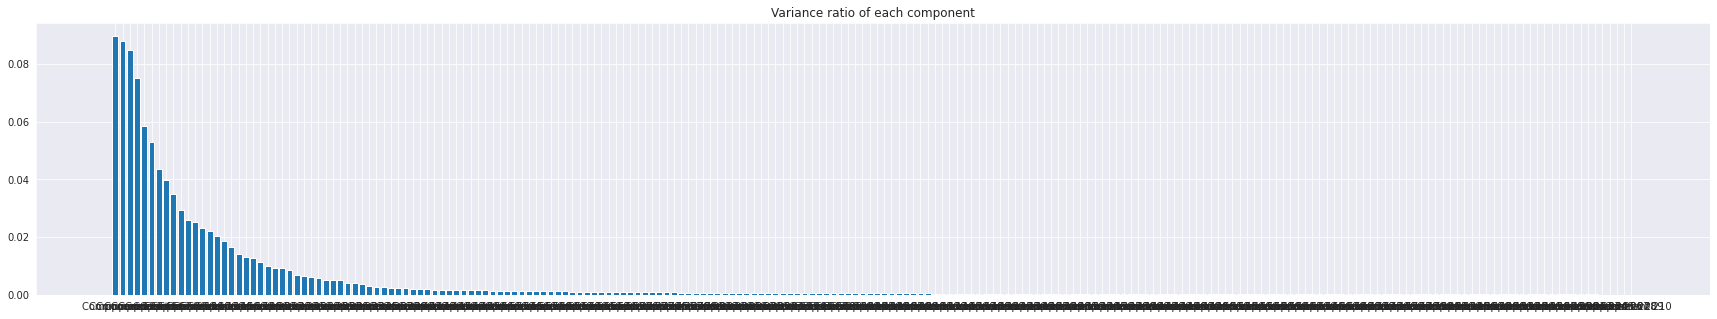

In [66]:
# According to variance ratio of each feature when n_components==original feature szie, many features can be dropped
pca = PCA(n_components=x_train.shape[1],svd_solver='auto')
x_train_all_pca = pca.fit_transform(x_train_all)
var_ratio=pca.explained_variance_ratio_

fig=plt.figure(figsize=(30,5))
plt.bar([i+1 for i in range(len(var_ratio))], var_ratio)
plt.xticks([i+1 for i in range(len(var_ratio))], ['Component '+str(i) for i in [i+1 for i in range(len(var_ratio))]])
plt.title('Variance ratio of each component')
plt.show()

In [0]:
# PCA to get 90% cumulative variance in total
pca = PCA(n_components=0.90)
x_train_all_pca = pca.fit_transform(x_train_all)
x_train_pca = pca.transform(x_train)
x_valid_pca = pca.transform(x_valid)
x_test_pca = pca.transform(x_test)

In [68]:
print('x_train_all: {}; y_train_all: {}.'.format(x_train_all_pca.shape, y_train_all.shape))
print('x_train: {}; y_train: {}.'.format(x_train_pca.shape, y_train.shape))
print('x_valid: {}; y_valid: {}.'.format(x_valid_pca.shape, y_valid.shape))
print('x_test: {}; y_test: {}.'.format(x_test_pca.shape, y_test.shape))

x_train_all: (5482, 39); y_train_all: (5482, 1).
x_train: (4111, 39); y_train: (4111, 1).
x_valid: (1371, 39); y_valid: (1371, 1).
x_test: (1828, 39); y_test: (1828, 1).


#### 5.2 K-Nearest Neighbors

In [69]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train_pca, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

Accuracy Score based on 5-fold Cross Validation: 0.72



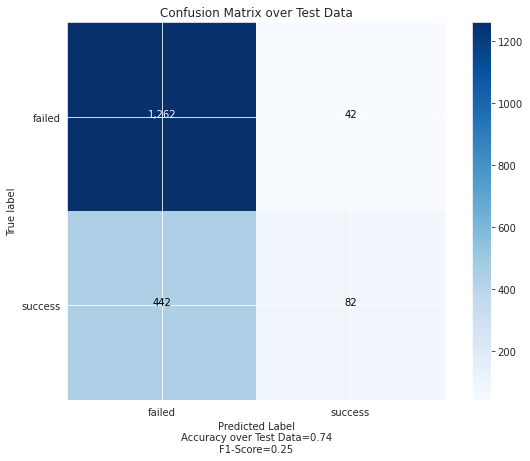

In [70]:
model_selection(knn, x_train_all_pca, y_train_all, x_train_pca, y_train, x_test_pca, y_test)

#### 5.3 Decision Tree

In [71]:
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=20, min_samples_leaf=10)
decision_tree.fit(x_train_pca, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy Score based on 5-fold Cross Validation: 0.67



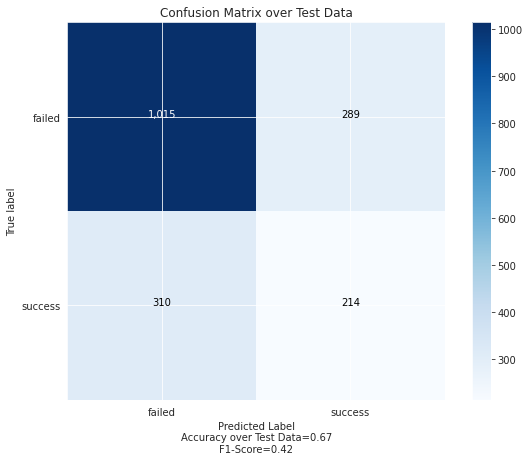

In [72]:
model_selection(decision_tree, x_train_all_pca, y_train_all, x_train_pca, y_train, x_test_pca, y_test)

####  DNN

In [0]:
dnn_model=Sequential([
                  Dense(32, input_dim=x_train_pca.shape[1],activation='relu'),
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation='sigmoid')])

In [74]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1280      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,953
Trainable params: 1,953
Non-trainable params: 0
_________________________________________________________________


In [0]:
dnn_model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])

In [76]:
dnn_model.fit(x_train_pca, y_train, batch_size=512, epochs=50, validation_data=(x_valid_pca, y_valid))

Train on 4111 samples, validate on 1371 samples
Epoch 1/50
4111/4111 [==============================] - 0s 42us/step - loss: 0.6805 - accuracy: 0.6244 - val_loss: 0.6690 - val_accuracy: 0.6929
Epoch 2/50
4111/4111 [==============================] - 0s 7us/step - loss: 0.6618 - accuracy: 0.7057 - val_loss: 0.6515 - val_accuracy: 0.6995
Epoch 3/50
4111/4111 [==============================] - 0s 6us/step - loss: 0.6451 - accuracy: 0.7103 - val_loss: 0.6355 - val_accuracy: 0.6980
Epoch 4/50
4111/4111 [==============================] - 0s 6us/step - loss: 0.6291 - accuracy: 0.7100 - val_loss: 0.6203 - val_accuracy: 0.6980
Epoch 5/50
4111/4111 [==============================] - 0s 6us/step - loss: 0.6144 - accuracy: 0.7100 - val_loss: 0.6072 - val_accuracy: 0.6980
Epoch 6/50
4111/4111 [==============================] - 0s 6us/step - loss: 0.6029 - accuracy: 0.7100 - val_loss: 0.5976 - val_accuracy: 0.6980
Epoch 7/50
4111/4111 [==============================] - 0s 6us/step - loss: 0.5943 - ac

In [77]:
y_pred = dnn_model.predict_classes(x_test_pca)
accuracy_score(y_test,y_pred)

0.7308533916849015

In [78]:
dnn_model.evaluate(x_test_pca, y_test, verbose=1)

1828/1828 [==============================] - 0s 19us/step


[0.5362598793642265, 0.7308533787727356]